<a href="https://colab.research.google.com/github/yibowang15/Capstone/blob/VGG16-Initialization/Mean_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import shutil
# import os

# # 定义要删除的目录路径
# training_data_dir = '/content/ValidationData'

# # 删除整个目录及其内容
# if os.path.exists(training_data_dir):
#     shutil.rmtree(training_data_dir)
#     print(f"Deleted directory: {training_data_dir}")
# else:
#     print(f"Directory not found: {training_data_dir}")

Directory not found: /content/ValidationData


In [ ]:
import shutil
import os

# 复制训练数据到本地
!cp -r /content/drive/MyDrive/CapstoneProject/data/TrainingData /content/

# 复制验证数据到本地
!cp -r /content/drive/MyDrive/CapstoneProject/data/ValidationData /content/

In [ ]:
import os
import tensorflow.keras.applications
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from keras.applications.vgg16 import VGG16
from keras.models import load_model, Model
from keras.layers import Input, Conv2D, MaxPooling2D

from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

model = VGG16(weights='imagenet', include_top=False)

# Block1_conv1 weights are of the format [3, 3, 3, 64] -> this is for RGB images
# For grayscale, format should be [3, 3, 1, 64]. Weighted average of the features has to be calculated across channels.
# RGB weights: Red 0.2989, Green 0.5870, Blue 0.1140

# getting weights of block1 conv1.
block1_conv1 = model.get_layer('block1_conv1').get_weights()
weights, biases = block1_conv1

# :weights shape = [3, 3, 3, 64] - (0, 1, 2, 3)
# convert :weights shape to = [64, 3, 3, 3] - (3, 2, 0, 1)
weights = np.transpose(weights, (3, 2, 0, 1))


kernel_out_channels, kernel_in_channels, kernel_rows, kernel_columns = weights.shape

# Dimensions : [kernel_out_channels, 1 (since grayscale), kernel_rows, kernel_columns]
grayscale_weights = np.zeros((kernel_out_channels, 1, kernel_rows, kernel_columns))

# iterate out_channels number of times
for i in range(kernel_out_channels):

	# get kernel for every out_channel
	get_kernel = weights[i, :, :, :]

	temp_kernel = np.zeros((3, 3))

	# :get_kernel shape = [3, 3, 3]
	# axis, dims = (0, in_channel), (1, row), (2, col)

	# calculate weighted average across channel axis
	in_channels, in_rows, in_columns = get_kernel.shape

	for in_row in range(in_rows):
		for in_col in range(in_columns):
			feature_red = get_kernel[0, in_row, in_col]
			feature_green = get_kernel[1, in_row, in_col]
			feature_blue = get_kernel[2, in_row, in_col]

			# weighted average for RGB filter
			total = (feature_red * 1/3) + (feature_green * 1/3) + (feature_blue * 1/3)

			temp_kernel[in_row, in_col] = total


	# :temp_kernel is a 3x3 matrix [rows x columns]
	# add an axis at the end to specify in_channel as 1

	# 2 ways of doing this,

	# First: Add axis directly at the end of :temp_kernel to make its shape: [3, 3, 1], but this might be
	# an issue when concatenating all feature maps

	# Second: Add axis at the start of :temp_kernel to make its shape: [1, 3, 3] which is [in_channel, rows, columns]
	temp_kernel = np.expand_dims(temp_kernel, axis=0)

	# Now, :temp_kernel shape is [1, 3, 3]

	# Concat :temp_kernel to :grayscale_weights along axis=0
	grayscale_weights[i, :, :, :] = temp_kernel

# Dimension of :grayscale_weights is [64, 1, 3, 3]
# In order to bring it to tensorflow or keras weight format, transpose :grayscale_weights

# dimension, axis of :grayscale_weights = (out_channels: 0), (in_channels: 1), (rows: 2), (columns: 3)
# tf format of weights = (rows: 0), (columns: 1), (in_channels: 2), (out_channels: 3)

# Go from (0, 1, 2, 3) to (2, 3, 1, 0)
grayscale_weights = np.transpose(grayscale_weights, (2, 3, 1, 0)) # (3, 3, 1, 64)

# combine :grayscale_weights and :biases
new_block1_conv1 = [grayscale_weights, biases]


# Reconstruct the layers of VGG16 but replace block1_conv1 weights with :grayscale_weights

# get weights of all the layers starting from 'block1_conv2'
vgg16_weights = {}
for layer in model.layers[2:]:
	if "conv" in layer.name:
		vgg16_weights["1024_" + layer.name] = model.get_layer(layer.name).get_weights()

del model


# Custom build VGG16
input = Input(shape=(224, 224, 1), name='224_input')
# Block 1
x = Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(1024, 1024, 1), data_format="channels_last", name='1024_block1_conv1')(input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='1024_block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='1024_block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='1024_block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='1024_block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='1024_block2_pool')(x)

# Block 3
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='1024_block3_conv1')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='1024_block3_conv2')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='1024_block3_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='1024_block3_pool')(x)

# Block 4
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='1024_block4_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='1024_block4_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='1024_block4_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='1024_block4_pool')(x)

# Block 5
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='1024_block5_conv1')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='1024_block5_conv2')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='1024_block5_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='1024_block5_pool')(x)

base_model = Model(inputs=input, outputs=x)

base_model.get_layer('1024_block1_conv1').set_weights(new_block1_conv1)
for layer in base_model.layers[2:]:
	if 'conv' in layer.name:
		base_model.get_layer(layer.name).set_weights(vgg16_weights[layer.name])

# # 2. 冻结所有卷积层
# for layer in base_model.layers:
# 	  layer.trainable = False  # 将所有层的trainable属性设置为False
# # 解冻最后的几层卷积层，例如block5的卷积层
# for layer in base_model.layers[-6:]:  # 解冻最后6层
#     layer.trainable = True

# Add Flatten Layer
x = Flatten(name = 'Flatten')(base_model.output)  # Flatten

# Add two fully connected layers (4096 hidden units) and their corresponding Dropout Layers
x = Dense(4096, activation='relu', name = 'FC1')(x)
x = Dropout(0.5, name = 'Dropout1')(x)  # Dropout ratio set to 0.5
x = Dense(4096, activation='relu', name = 'FC2')(x)
x = Dropout(0.5, name = 'Dropout2')(x)

# Add binary classification dense layer(Using Sigmoid)
x = Dense(1, activation='sigmoid', name = 'Output_Layer_Classification')(x)

base_model = Model(inputs=base_model.input, outputs=x)
base_model.summary()

#print base_model.get_layer('block3_conv2').get_weights()
base_model.save('my_model.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 224_input (InputLayer)               │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1024_block1_conv1 (Conv2D)           │ (None, 224, 224, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1024_block1_conv2 (Conv2D)           │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1024_block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1024_block2_conv1 (Conv2D)           │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1024_block2_conv2 (Conv2D)           │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1024_block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1024_block3_conv1 (Conv2D)           │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1024_block3_conv2 (Conv2D)           │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1024_block3_conv3 (Conv2D)           │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1024_block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1024_block4_conv1 (Conv2D)           │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1024_block4_conv2 (Conv2D)           │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1024_block4_conv3 (Conv2D)           │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1024_block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1024_block5_conv1 (Conv2D)           │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1024_block5_conv2 (Conv2D)           │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1024_block5_conv3 (Conv2D)           │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1024_block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,263,489 (512.17 MB)

 Trainable params: 134,263,489 (512.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Initialize learning rate and momentum
opt = SGD(learning_rate = 0.0001, momentum=0.9)

# from tensorflow.keras.optimizers import Adam

# # Initialize Adam optimizer
# opt = Adam(learning_rate=0.001)  # 你可以根据需要调整 learning_rate

# Use loss = 'binary_crossentropy' (Sigmoid)
base_model.compile(optimizer= opt, loss='binary_crossentropy', metrics=['accuracy'])

# Use loss = 'categorical_crossentropy'（Softmax)
#final_model.complie(optimizer = opt, loss='categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
import os
import shutil
import pandas as pd

# Load training and validation data from CSV files (or prepare the data)
df_training = pd.read_csv('/content/drive/MyDrive/CapstoneProject/data/df_training.csv')

# Convert labels from 0/1 to 'cat'/'dog' for binary classification
df_training['category'] = df_training['category'].replace({0: 'cat', 1: 'dog'})

# 定义源文件夹和目标文件夹路径
source_dir = '/content/TrainingData'  # 原始的 TrainingData 文件夹
cat_dir = os.path.join(source_dir, 'cat')  # 猫的子文件夹
dog_dir = os.path.join(source_dir, 'dog')  # 狗的子文件夹

# 创建目标文件夹（如果不存在）
os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

# 遍历CSV文件中的每一行，根据类别移动图像到对应子文件夹
for index, row in df_training.iterrows():
    filename = row['filename']
    category = row['category']  # 类别应该是 'cat' 或 'dog'

    # 根据类别确定目标文件夹
    if category == 'cat':
        target_dir = cat_dir
    elif category == 'dog':
        target_dir = dog_dir
    else:
        continue  # 如果类别不为 'cat' 或 'dog'，跳过

    # 定义源文件路径和目标文件路径
    source_path = os.path.join(source_dir, filename)
    target_path = os.path.join(target_dir, filename)

    # 检查文件是否存在于源目录
    if os.path.exists(source_path):
        # 移动文件到目标目录
        shutil.move(source_path, target_path)
        print(f"Moved {filename} to {target_dir}")
    else:
        print(f"File {filename} not found in {source_dir}")

print("File moving completed.")


流式输出内容被截断，只能显示最后 5000 行内容。
Moved cat.10594.jpg to /content/TrainingData/cat
Moved cat.4788.jpg to /content/TrainingData/cat
Moved cat.7359.jpg to /content/TrainingData/cat
Moved dog.3842.jpg to /content/TrainingData/dog
Moved cat.9120.jpg to /content/TrainingData/cat
Moved cat.10143.jpg to /content/TrainingData/cat
Moved cat.9261.jpg to /content/TrainingData/cat
Moved cat.2330.jpg to /content/TrainingData/cat
Moved dog.776.jpg to /content/TrainingData/dog
Moved cat.5938.jpg to /content/TrainingData/cat
Moved dog.10798.jpg to /content/TrainingData/dog
Moved dog.5170.jpg to /content/TrainingData/dog
Moved cat.11599.jpg to /content/TrainingData/cat
Moved cat.7136.jpg to /content/TrainingData/cat
Moved dog.8266.jpg to /content/TrainingData/dog
Moved dog.1027.jpg to /content/TrainingData/dog
Moved dog.11792.jpg to /content/TrainingData/dog
Moved cat.5560.jpg to /content/TrainingData/cat
Moved cat.10090.jpg to /content/TrainingData/cat
Moved cat.9710.jpg to /content/TrainingData/cat
Moved do

In [ ]:
import os
import shutil
import pandas as pd

# 读取CSV文件
df_validation = pd.read_csv('/content/drive/MyDrive/CapstoneProject/data/df_validation.csv')

# Convert labels from 0/1 to 'cat'/'dog' for binary classification
df_validation['category'] = df_validation['category'].replace({0: 'cat', 1: 'dog'})

# 定义源文件夹和目标文件夹路径
source_dir = '/content/ValidationData'  # 原始的 ValidationData 文件夹
cat_dir = os.path.join(source_dir, 'cat')  # 猫的子文件夹
dog_dir = os.path.join(source_dir, 'dog')  # 狗的子文件夹

# 创建目标文件夹（如果不存在）
os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

# 遍历CSV文件中的每一行，根据类别移动图像到对应子文件夹
for index, row in df_validation.iterrows():
    filename = row['filename']
    category = row['category']  # 类别应该是 'cat' 或 'dog'

    # 根据类别确定目标文件夹
    if category == 'cat':
        target_dir = cat_dir
    elif category == 'dog':
        target_dir = dog_dir
    else:
        continue  # 如果类别不为 'cat' 或 'dog'，跳过

    # 定义源文件路径和目标文件路径
    source_path = os.path.join(source_dir, filename)
    target_path = os.path.join(target_dir, filename)

    # 检查文件是否存在于源目录
    if os.path.exists(source_path):
        # 移动文件到目标目录
        shutil.move(source_path, target_path)
        print(f"Moved {filename} to {target_dir}")
    else:
        print(f"File {filename} not found in {source_dir}")

print("Validation data has been moved into 'cat' and 'dog' folders.")

Moved dog.888.jpg to /content/ValidationData/dog
Moved cat.3243.jpg to /content/ValidationData/cat
Moved cat.11707.jpg to /content/ValidationData/cat
Moved cat.10557.jpg to /content/ValidationData/cat
Moved cat.8942.jpg to /content/ValidationData/cat
Moved dog.12094.jpg to /content/ValidationData/dog
Moved cat.8199.jpg to /content/ValidationData/cat
Moved dog.9127.jpg to /content/ValidationData/dog
Moved dog.6791.jpg to /content/ValidationData/dog
Moved cat.5338.jpg to /content/ValidationData/cat
Moved cat.12344.jpg to /content/ValidationData/cat
Moved dog.3568.jpg to /content/ValidationData/dog
Moved dog.3701.jpg to /content/ValidationData/dog
Moved cat.10201.jpg to /content/ValidationData/cat
Moved cat.3211.jpg to /content/ValidationData/cat
Moved cat.482.jpg to /content/ValidationData/cat
Moved cat.11207.jpg to /content/ValidationData/cat
Moved dog.4762.jpg to /content/ValidationData/dog
Moved cat.1700.jpg to /content/ValidationData/cat
Moved dog.11417.jpg to /content/ValidationData

Found 20000 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Training samples:  20000
Validation samples:  2500
Epoch 1/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.5179 - loss: 0.7548
Epoch 1: val_accuracy improved from -inf to 0.71998, saving model to /content/best_model.keras
156/156 ━━━━━━━━━━━━━━━━━━━━ 45s 255ms/step - accuracy: 0.5181 - loss: 0.7546 - val_accuracy: 0.7200 - val_loss: 0.5951 - learning_rate: 1.0000e-04
Epoch 2/15
  1/156 ━━━━━━━━━━━━━━━━━━━━ 33s 216ms/step - accuracy: 0.6172 - loss: 0.6544
Epoch 2: val_accuracy did not improve from 0.71998
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6172 - loss: 0.6544 - val_accuracy: 0.6912 - val_loss: 0.5837 - learning_rate: 1.0000e-04
Epoch 3/15
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6475 - loss: 0.6231
Epoch 3: val_accuracy improved from 0.71998 to 0.77303, saving model to /content/best_model.keras
156/156 ━━━━━━━━━━━━━━━━━━━━ 37s 235ms/step - accuracy: 0.6477

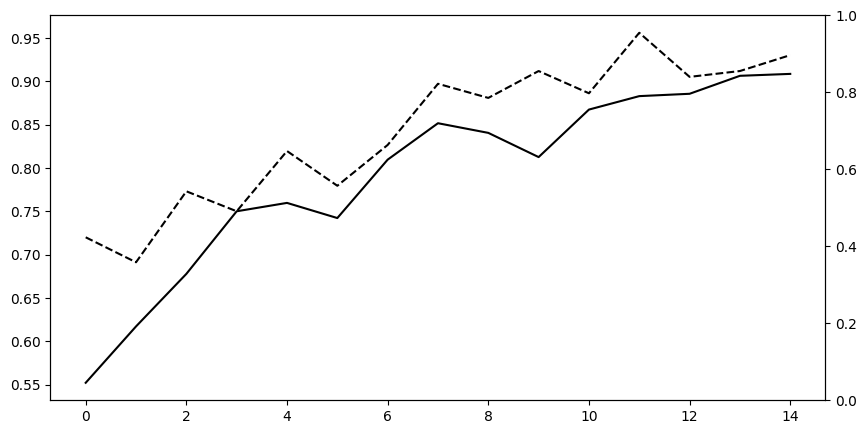

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD

# Create data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Training data generator using flow_from_directory
train_generator = train_datagen.flow_from_directory(
    directory='/content/TrainingData',  # 指向包含 cat 和 dog 文件夹的主目录
    target_size=(224, 224),  # 输入尺寸（VGG16 要求）
    batch_size=128,
    class_mode='binary',  # 二分类
    color_mode='grayscale'  # 使用灰度图像
)

# Validation data generator using flow_from_directory
validation_generator = validation_datagen.flow_from_directory(
    directory='/content/ValidationData',  # Validation 主目录
    target_size=(224, 224),  # 输入尺寸
    batch_size=128,
    class_mode='binary',
    color_mode='grayscale'
)
# Checkpoint callback to save the best model based on validation accuracy
checkpoint_path = '/content/best_model.keras'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
# Check whether the generators work properly
print("Training samples: ", train_generator.samples)
print("Validation samples: ", validation_generator.samples)

# Initialize learning rate and momentum
opt = SGD(learning_rate = 0.0001, momentum=0.9)
# # Initialize Adam optimizer
# opt = Adam(learning_rate=0.001)  # 你可以根据需要调整 learning_rate
# Use loss = 'binary_crossentropy' (Sigmoid)
base_model.compile(optimizer= opt, loss='binary_crossentropy', metrics=['accuracy'])

# 设置回调函数
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# 训练模型时添加回调函数
try:
    history = base_model.fit(
        train_generator,  # 训练数据生成器
        steps_per_epoch=train_generator.samples // train_generator.batch_size,  # 每个 epoch 的步数
        epochs=15,  # 训练的 epoch 数量
        validation_data=validation_generator,  # 验证数据生成器
        validation_steps=validation_generator.samples // validation_generator.batch_size,  # 每个 epoch 的验证步数
        callbacks=[reduce_lr, early_stopping, checkpoint]  # 添加回调函数
    )

    # 在训练完成后，获取学习率并绘制曲线图
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # 获取每个 epoch 的学习率
    lrs = [float(base_model.optimizer.learning_rate.numpy()) for epoch in range(8)]

    # 获取每个 epoch 的训练准确率和验证准确率
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs_range = range(len(acc))  # x 轴范围

    # 创建图形
    plt.figure(figsize=(10, 5))

    # 绘制训练与验证准确率曲线
    plt.plot(epochs_range, acc, label='Training', color='black')  # 实线
    plt.plot(epochs_range, val_acc, label='Validation', color='black', linestyle='dashed')  # 虚线

    # 设置右侧 y 轴并绘制学习率曲线
    ax2 = plt.gca().twinx()  # 共享 x 轴
    ax2.plot(epochs_range, lrs, label='Learning rate', color='gray')  # 学习率曲线为灰色
    ax2.set_yscale('log')  # 设置学习率为对数刻度
    ax2.set_ylabel('Learning rate', fontsize=12)

    # 设置标题和轴标签
    plt.title('(a)', loc='left', fontsize=12)  # 设置标题
    plt.xlabel('Epoch', fontsize=12)  # x 轴
    plt.ylabel('Accuracy', fontsize=12)  # 左侧 y 轴为准确率
    # 设置左侧 Y 轴范围，减小波动
    plt.ylim(0.7, 1.0)  # 调整范围为 0.7 到 1.0

    # 手动设置左侧 Y 轴的刻度
    plt.yticks(np.arange(0.7, 1.01, 0.05))  # 每 0.05 作为一个间隔

    # 设置 y 轴刻度为科学计数法
    ax2.tick_params(axis='y', which='both', labelsize=10)

    # 设置图例位置
    plt.legend(loc='best', fontsize=10)

    # 显示图形
    plt.show()

except Exception as e:
    print(f"Error during training: {e}")
